### "along_isf" to avoid confusion with ALL ISF survey variables, filenames and titles

In [6]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import scipy
import matplotlib.patches as patches
import pandas as pd
from scipy.io import readsav
from regions import Regions #read_ds9, write_ds9
import csv
import math
from scipy.optimize import curve_fit
import time
from pathlib import Path
from pyds9 import ds9
from scipy.integrate import quad
from astropy.table import QTable, Table, Column, vstack
from astropy.visualization.stretch import AsinhStretch
from astropy.visualization import ImageNormalize, simple_norm
import matplotlib.patches as patches
import pymc as pm
import arviz as az
import random

In [7]:
hdr = fits.getheader('ISF_Mosaic_Trial5_drz_sci.fits')
im  = fits.getdata('ISF_Mosaic_Trial5_drz_sci.fits')
wcs = WCS(hdr)

In [8]:
def write_regf(ra, dec, fname, c, text, r=None, update=False):
    """
    fname - file name to be written
    c - region color
    """
    xx, yy = ra, dec
    text = np.array(text, dtype=str)
    if r==None:
        r =25
    else:
        r=r
    if update == True:
        with open(fname) as unt:
            lines = unt.readlines()
        with open(fname, 'w') as unt:    
            unt.writelines(lines)

            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')
    else:
        with open(fname, 'w') as unt:
            unt.write('fk5')
            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')

In [9]:
def norm_logistic_reg(x, mu, sig):
    w = 1/(1+np.exp(-((x-mu)/sig)))
    return w

def r_times_logistic_reg(x, m, s):
    w = x/(1+np.exp(-((x-m)/s)))
    return w

In [10]:
df_params = pd.read_csv('mu_sig_params.csv')
mu, sig = np.array(df_params['mu']), np.array(df_params['sig'])
df_flame = pd.read_csv('dm_sep_flame.csv')
sep_flame, dm_flame = np.array(df_flame['sep']), np.array(df_flame['dm'])

In [11]:
df_final = pd.read_csv('dash_rereduce_removed_combined_with_rereduceII_with_VISION.csv')
df_final2 = df_final
ra_f2 = np.array(df_final2['RA_d'])
dec_f2 = np.array(df_final2['DEC_d'])
m_f2 = np.array(df_final2['MAG_d'])
me_f2 = np.array(df_final2['MAG_d_unc'])
h_f2 = np.array(df_final2['H_v'])
he_f2 = np.array(df_final2['He_v'])
k_f2 = np.array(df_final2['Ks_v'])
ke_f2 = np.array(df_final2['Kse_v'])
fwhm_f2 = np.array(df_final2['FWHM_d'])
rsat_f2 = np.array(df_final2['R_SAT_d'])
clas_f2 = np.array(df_final2['class'], dtype=str)

yso_clas = np.array(['protostars', 'disks', 'td', 'nd_proto_faint'])
proto_clas = np.array(['protostars', 'nd_proto_faint'])
prems_clas = np.array(['disks', 'td'])

i_yso, = np.where(np.isin(clas_f2, yso_clas))
i_proto, = np.where(np.isin(clas_f2, proto_clas))
i_prems, = np.where(np.isin(clas_f2, prems_clas))

In [18]:
df_allisf = pd.read_csv('Along_ISF_object_list.csv')
ind_allisf = np.array(df_allisf['ISF'])
yso_allisf = np.array(df_allisf['yso'])

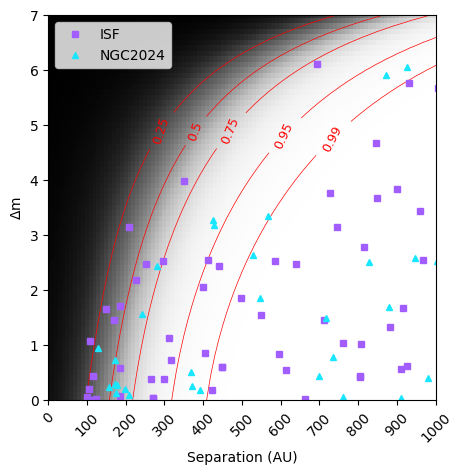

In [19]:
dms = np.arange(0, 7.01, 1/10)
seps = np.arange(0, 2001., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])
    
cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](np.linspace(0.10, 0.85, 8))

fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")


c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='r', alpha=0.99, linewidths=0.5)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='r', alpha=0.99, linewidths=0.5)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='r', alpha=0.99, linewidths=0.5)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='r', alpha=0.99, linewidths=0.5)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='r', alpha=0.99, linewidths=0.5)

xt = ax.get_xticks()
#ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
ax.set_xticks(np.arange(0, 201, 10), np.arange(0, 2001, 100), rotation=45)
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))


manual_locations = [(20, 50)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 50)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 50)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 50)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 50)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=400.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])
r_comp = np.array([])
dc_comp = np.array([])
mag_prim = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.)&(m_yso[i]>12.):
        ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
        dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
        m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        N_cand  = N_cand + len(i_comp)
        ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
        ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
        m_prim = m_sys[i_prim]
        c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

        c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
        sep_comp = c_comp.separation(c_prim).arcsec*400.
        #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        d_comp = np.append(d_comp, sep_comp)
        dm_comp = np.append(dm_comp, np.abs((m_sys[i_comp]-m_prim)))
        r_comp, dc_comp = np.append(r_comp, ra_comp), np.append(dc_comp, dec_comp)
        mag_prim = np.append(mag_prim, np.ones(ra_comp.shape)*m_prim[0])
ax.plot(d_comp/10, dm_comp*10, 's', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')

ax.set_yticks(np.arange(0, 71, 10), np.arange(0, 8, 1))
ax.set_ylim(0, 70)

ax.set_xlim(0, 100)
ax.legend()

In [113]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
    N_total = len(i_yso) #Total number of YSOs
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    bw = 100
    bins = (np.zeros((len(i_yso), len(np.arange(1, 5000/bw+1, 1)))))
    bin_count = np.arange(1, 5000/bw+1, 1, dtype=int)

    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=400.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    cont_m  = np.array([])
    #fig, ax = plt.subplots()
    
    n_cont_INT = 0
    
    for i in range(N_total):
        
        
        #Making a catalog object using the ith YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        
        for i_bin in bin_count:
            i_obj_bin,  = np.where((sep_>=i_bin*bw)&(sep_<=(i_bin*bw+bw)))
            bins[i,i_bin-1] = np.sum(i_obj_bin)
                                 
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            if len(i_tested)==0:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=False)
            else:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=True)
            
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            
            m_prim = m_sys[i_prim]
            m_comp = m_sys[i_comp]
            
            if np.abs(m_comp - m_prim).any() <= 7.0:
                i_comp = i_comp[np.abs(m_comp - m_prim)<=7.0]
                m_comp = m_sys[i_comp]

                ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
                ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]

                c_comp   = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
                c_prim   = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
                sep_comp = c_comp.separation(c_prim).arcsec*400.

                #making a new cat obj with the dimmest objects in the system
                #n_obj is recalculated using the "new" primary.
                sep      = c2.separation(c_prim).arcsec*400.
                i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
                n_obj    = len(i_obj_)
                N_cand   = N_cand + n_obj
                i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
                
        else:
            m_prim   = m_yso[i]
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont      = 0
        #if len(i_cont)>0: #N_contaminants is calculated around all YSOs in the region.
        for j in range(len(i_cont)):
            delta_m = m_cat[i_cont[j]]-m_prim
            cont_m = np.append(cont_m, m_cat[i_cont[j]])
            dm_int  = int(10*np.round(delta_m, 1))
            if (dm_int>70)|(dm_int<0): #80: delta_mag=8
                mu_, sig_ = 0, 0
                R_ = 0
            else:
                mu_  = mu[dm_int]
                sig_ = sig[dm_int]
                I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                R  = np.append(R, R_)
                d_mag=np.append(d_mag,dm_int)
                R_unc   = np.append(R_unc, I[1])
                dist = np.append(dist, sep_[i_cont[j]])
                n_cont_INT = n_cont_INT + 1
            n_cont  = n_cont + R_
            


        N_cont_corr = np.append(N_cont_corr, n_cont)
        N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                      len(i_cont)*
                                      (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
        #N_cont = np.append(N_cont, n_cont)


        
            
        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
        
        
        
    N_comp   = N_cand - np.sum(N_cont_corr)
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: '+str(N_cand)+'/'+str(N_total))
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print(r'N_contaminants (with 0 gt del_m lt 7.): ', np.sum(n_cont_INT))
    print('N_comp: ', N_comp)
    print('CF:', N_comp/N_total)
    
    return d_mag, N_cont_corr, dist, cont_m, bins, bin_count, n_cont_INT

In [112]:
dmag, N_cont_arr, dist, cmag, sig_bins, bin_count, n_cont_INT  = CF(ra_f2, dec_f2, m_f2, ind_allisf[yso_allisf])

N_cand: 47/377
N_cont within 200-5000 (before correction):  21.544285714285714
N_cont within 200-5000:  16.650505552007253
N_contaminants:  457.0
N_contaminants (with 0 gt del_m lt 7.):  402
N_comp:  30.349494447992747
CF: 0.08050263779308421


In [114]:
dmag, N_cont_arr, dist, cmag, sig_bins, bin_count, n_cont_INT  = CF(ra_f2, dec_f2, m_f2, ind_allisf[yso_allisf])

N_cand: 47/377
N_cont within 200-5000 (before correction):  21.544285714285714
N_cont within 200-5000:  13.198844847451648
N_contaminants:  457.0
N_contaminants (with 0 gt del_m lt 7.):  324
N_comp:  33.801155152548354
CF: 0.0896582364789081


In [ ]:
324

In [22]:
bw=100
bin_radii = bin_count*bw
bin_areas = np.pi*((bin_radii)**2-(bin_radii-bw)**2)
bin_mean = np.mean(sig_bins, axis=0)/bin_areas

### P($<\Delta$r) = $\frac{r^2 - r^2_{1}}{r^2_{2} - r^2_{1}}$

$r_1$ = 100, 
$r_2$ = 1000

$r = \sqrt{N(r_2^2 - r_1^2) + r_1^2}$

In [23]:
def P_r(r):
    r1, r2 = 100, 1000
    return (r**2 - r1**2)/(r2**2 - r1**2)

def inv_P_r(n):
    r1, r2 = 100, 1000
    return np.sqrt(n*(r2**2 - r1**2) + r1**2)

Text(0, 0.5, 'f ($\\Delta$r)')

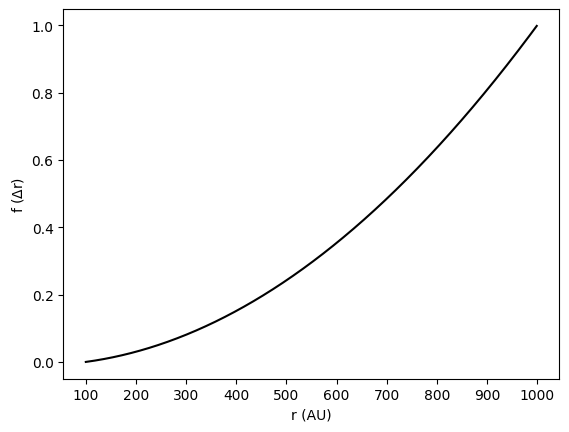

In [24]:
fig, ax = plt.subplots()
r1, r2 = 100, 1000
ax.plot(np.arange(100, 1000, 1), (np.arange(100, 1000, 1)**2 - r1**2)/(r2**2 - r1**2), 'k-')
ax.set_xticks(np.arange(100, 1100, 100))
ax.set_xlabel('r (AU)')
ax.set_ylabel('f ($\Delta$r)')

### P($<\Delta$m)

Text(0.5, 1.0, 'Along ISF')

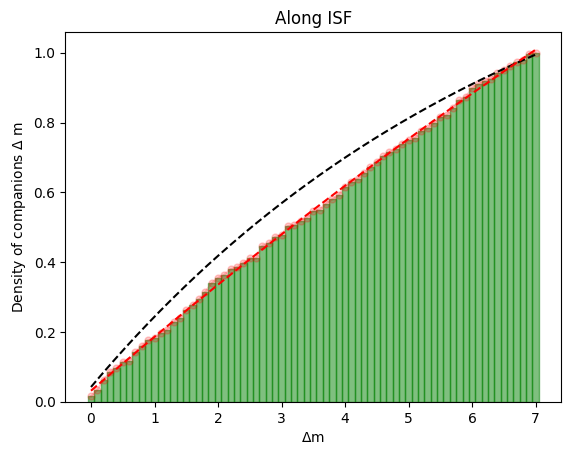

In [115]:
plt.subplot()
bw=100
n, bins, patches = plt.hist(dmag/10, bins=np.arange(-0.05, 7.051, 0.1),
                             cumulative=True, density=True,
                           color='green', alpha=0.5, edgecolor='g')
#plt.plot(bins[0:-1]+0.05, n, '.r')
plt.xlabel('$\Delta$m')
plt.ylabel('Density of companions $\Delta$ m')

#interpolated = pm.Interpolated.dist(np.arange(0, 8, 1), )
def parabola(x, a, b, c):
    return a - b*np.exp(-c*(x))
plt.plot(bins[0:-1]+0.05, n, 'r', ms=1, alpha=0.2)
plt.plot(bins[0:-1]+0.05, n, 'or', ms=5, alpha=0.2)
popt = np.array([1.53778978, 1.49562009, 0.14470388])
x = np.arange(0, 7.01, 0.01)
plt.plot(x, parabola(x, *popt), 'k--', ms=1)
popt, pcov = curve_fit(parabola, bins[0:-1]+0.05, n, p0=[1, 100, 1])
#mu = popt


plt.plot(x, parabola(x, *popt), 'r', linestyle='dashed', ms=1)
#plt.axhline(0.8)

def inv_delm(n, a, b, c):
    return -1/c*np.log((a - n)/b)

plt.title('Along ISF')

In [65]:
parabola(x[int(-0.5*100)], *popt)

0.9246633765081513

In [102]:
popt

array([4.55538634, 4.52381076, 0.03475942])

### P($<\Delta$m) = A - B $\cdot e^{-C \cdot x}$ (CDF),

where A = 1.19178628e+03, B = 1.15910484e+03, and C = 1.44704046e-01

### dP($<\Delta$m) = B$\cdot$C$\cdot e^{-C\cdot x} \cdot dx$ (PDF)

### $x = -\frac{ln[\frac{dP/dx}{BC}]}{C}$

## $P(\Sigma_{los} | N_{cont})= \frac{(\Sigma_{los}\Omega_{cont})^{N_{cont}}}{N_{cont}!}e^{-\Sigma_{los}\Omega_{cont}}$

### Poisson distribution = $\frac{\mu^{x}}{x!}\cdot e^{-\mu}$

$N_{cont} \sim Poisson()$

$P(\Sigma_{los} | N_{cont}) \sim Gamma()$

----

In [99]:
popt

array([4.55538634, 4.52381076, 0.03475942])

In [116]:
t1 = time.time() 
SEED = np.random.randint(100000)

SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":1000,
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

with pm.Model() as P_Ncont:
    sigma          = pm.Gamma('sig', alpha=324+1, beta=O_cont)
    y_obs          = pm.Poisson('Ncont', mu=sigma*O_comp)
    Ncont_trace    = pm.sample(**SAMPLE_KWARGS, progressbar=False)
    Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['sig', 'Ncont'], progressbar=False)
    
N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
a, b, c = popt

N_cont_det = np.array([])
for k in range(4000):
    chosen_N  = random.choice(N_)
    chosen_Ns = np.append(chosen_Ns, chosen_N)

    j = 0
    f_j = np.array([])
    while j < chosen_N:

        ran_decim   = np.random.randint(100000)/100000
        j_dm_       = inv_delm(ran_decim, a, b, c)
        if (j_dm_ > 7.):
            continue
        elif (j_dm_ < 0.):
            f_j = np.append(f_j, 0.)
            j += 1
        else:
            j_r_      = inv_P_r(ran_decim)
            j_dm, j_r = int(np.round(j_dm_, 1)*10), int(np.round(j_r_/10))
            f_j       = np.append(f_j, frac_mtx[j_dm,j_r])
            j += 1
    N_cont_det = np.append(N_cont_det, np.sum(f_j))
t2 = time.time()        


Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [sig]
>Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [Ncont, sig]


Text(0.5, 1.0, 'ISF (except M43 and the extended Orion nebula)')

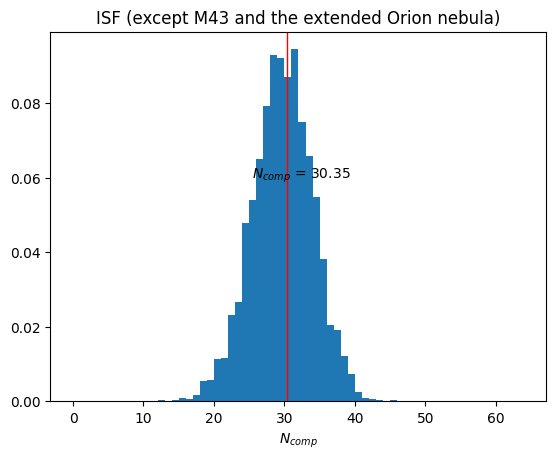

In [111]:
#del_m<70
plt.subplots()
plt.hist(47-N_cont_det, bins=np.arange(0, 65, 1), density=True)
plt.xlabel('$N_{comp}$')
plt.axvline(30.35, color='r', lw=1)
plt.text(30.35-5, 0.06, '$N_{comp}$ = 30.35')
plt.title('ISF (except M43 and the extended Orion nebula)')

Text(0.5, 1.0, 'ISF (except M43 and the extended Orion nebula)')

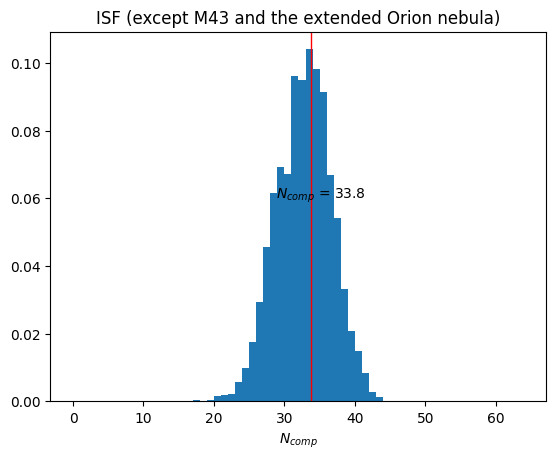

In [118]:
#0<del_m<7
plt.subplots()
plt.hist(47-N_cont_det, bins=np.arange(0, 65, 1), density=True)
plt.xlabel('$N_{comp}$')
plt.axvline(33.8, color='r', lw=1)
plt.text(33.8-5, 0.06, '$N_{comp}$ = 33.8')
plt.title('ISF (except M43 and the extended Orion nebula)')

Text(0.5, 1.0, 'ISF (except M43 and the extended Orion nebula)')

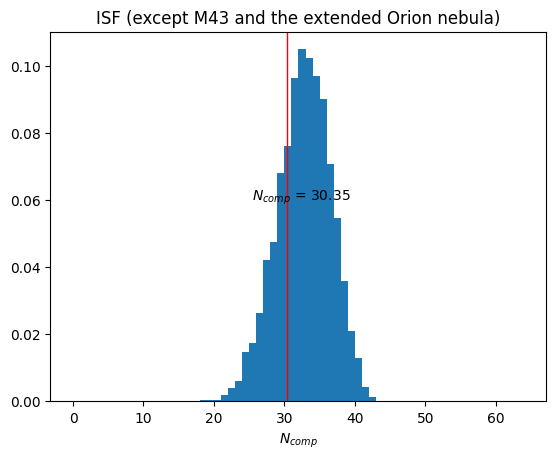

In [101]:
plt.subplots()
plt.hist(47-N_cont_det, bins=np.arange(0, 65, 1), density=True)
plt.xlabel('$N_{comp}$')
plt.axvline(30.35, color='r', lw=1)
plt.text(30.35-5, 0.06, '$N_{comp}$ = 30.35')
plt.title('ISF (except M43 and the extended Orion nebula)')

Text(0.5, 1.0, 'ISF (except M43 and the extended Orion nebula)')

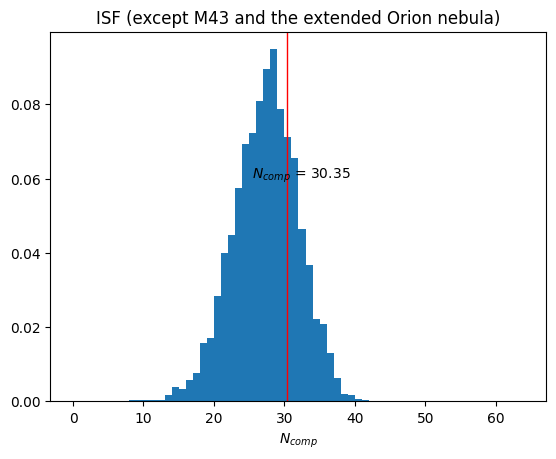

In [70]:
plt.subplots()
plt.hist(47-N_cont_det, bins=np.arange(0, 65, 1), density=True)
plt.xlabel('$N_{comp}$')
plt.axvline(30.35, color='r', lw=1)
plt.text(30.35-5, 0.06, '$N_{comp}$ = 30.35')
plt.title('ISF (except M43 and the extended Orion nebula)')

N_cand: 47/377

N_cont within 200-5000 (before correction):  21.544285714285714

N_cont within 200-5000:  16.650505552007253

N_contaminants:  457.0

N_comp:  30.349494447992747

CF: 0.08050263779308421

array([[<Axes: title={'center': 'Ncont'}>,
        <Axes: title={'center': 'Ncont'}>],
       [<Axes: title={'center': 'sig'}>, <Axes: title={'center': 'sig'}>]],
      dtype=object)

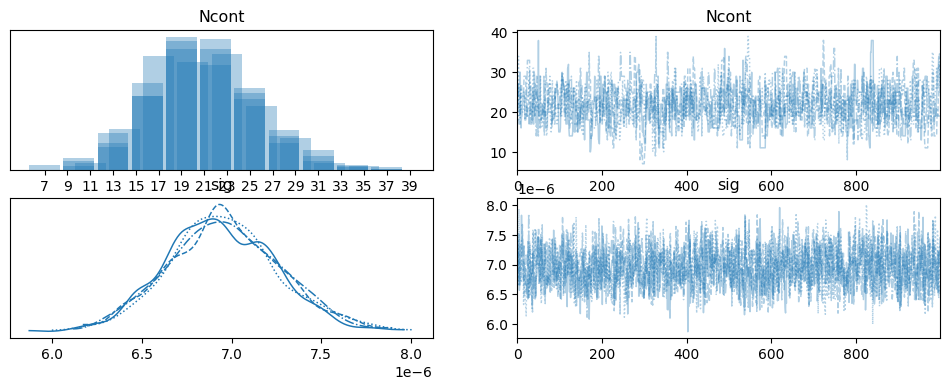

In [44]:
az.plot_trace(Ncont_trace)

In [63]:
scipy.special.factorial(np.arange(5, 45, 1, int))

array([1.20000000e+02, 7.20000000e+02, 5.04000000e+03, 4.03200000e+04,
       3.62880000e+05, 3.62880000e+06, 3.99168000e+07, 4.79001600e+08,
       6.22702080e+09, 8.71782912e+10, 1.30767437e+12, 2.09227899e+13,
       3.55687428e+14, 6.40237371e+15, 1.21645100e+17, 2.43290201e+18,
       5.10909422e+19, 1.12400073e+21, 2.58520167e+22, 6.20448402e+23,
       1.55112100e+25, 4.03291461e+26, 1.08888695e+28, 3.04888345e+29,
       8.84176199e+30, 2.65252860e+32, 8.22283865e+33, 2.63130837e+35,
       8.68331762e+36, 2.95232799e+38, 1.03331480e+40, 3.71993327e+41,
       1.37637531e+43, 5.23022617e+44, 2.03978821e+46, 8.15915283e+47,
       3.34525266e+49, 1.40500612e+51, 6.04152631e+52, 2.65827157e+54])

In [68]:
popt

array([65973445.72538566])

/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_54278/12276959.py:2: RuntimeWarning: overflow encountered in power
  return (lamb**k/scipy.special.factorial(k)) * np.exp(-lamb)
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_54278/12276959.py:2: RuntimeWarning: invalid value encountered in multiply
  return (lamb**k/scipy.special.factorial(k)) * np.exp(-lamb)


''

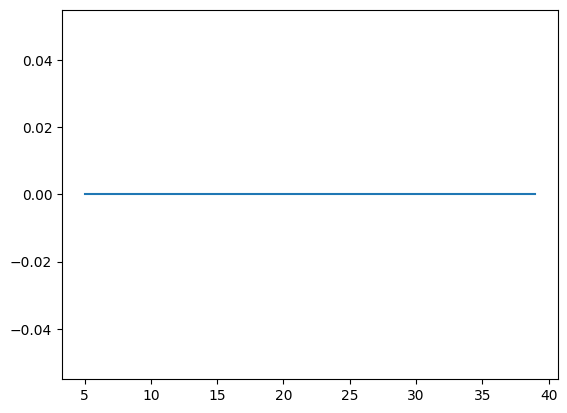

In [67]:
def poisson(k, lamb):
    return (lamb**k/scipy.special.factorial(k)) * np.exp(-lamb)

plt.subplots()
n, b, c = plt.hist(chosen_Ns, bins=np.arange(0, 65, 1), density=True)

popt, pcov = curve_fit(poisson, b[0:-1], n, p0=[O_cont])
x = np.arange(5, 45, 1)
plt.plot(x, poisson(x, *popt))
;

In [42]:
n

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00025   , 0.00025   , 0.00216667,
       0.00241667, 0.00616667, 0.01083333, 0.01783333, 0.02266667,
       0.03433333, 0.04366667, 0.05316667, 0.06675   , 0.07241667,
       0.08266667, 0.09008333, 0.07825   , 0.08116667, 0.06375   ,
       0.06166667, 0.05066667, 0.04141667, 0.03733333, 0.02333333,
       0.01633333, 0.01583333, 0.00891667, 0.00533333, 0.00375   ,
       0.00225   , 0.00241667, 0.00083333, 0.00041667, 0.00033333,
       0.00033333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

----

In [27]:
N_cand = 1
r1, r2 = 100, 1000
r3, r4 = 2000, 5000
O_comp = np.pi*(r2**2 - r1**2)
O_cont = np.pi*(r4**2 - r3**2)

#N_cont_ = N_cont_arr
#sig_los = N_cont_arr/O_cont * np.pi * (r2**2 - r1**2)

In [28]:
chosen_Ns = np.array([])
chosen_sigs = np.array([])
arr_seeds = np.array([])
N_cont_det = np.array([])
a, b, c   = popt

In [18]:
len(chosen_Ns),len(chosen_sigs),len(arr_seeds),len(N_cont_det)

(0, 0, 0, 0)

In [43]:
for i in range(200):
    print('Loop '+str(i))
    SEED = np.random.randint(100000)
    SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":1000,
                             "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
    with pm.Model() as P_siglos:
        y_obs = pm.Gamma('sig', alpha=33+1, beta=O_cont)
        sig_trace = pm.sample(**SAMPLE_KWARGS, progressbar=False)
        sig_forecast = pm.sample_posterior_predictive(sig_trace, var_names=['sig'], progressbar=False)

    sig_       = sig_forecast.posterior_predictive['sig'].data.flatten()
    chosen_sig = random.choice(sig_)
    chosen_sigs = np.append(chosen_sigs, chosen_sig)

    SEED = np.random.randint(100000)
    arr_seeds = np.append(arr_seeds, SEED)

    SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":1000,
                     "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

    with pm.Model() as P_Ncont:
        y_obs          = pm.Poisson('Ncont', mu=chosen_sig*O_comp)
        Ncont_trace    = pm.sample(**SAMPLE_KWARGS, progressbar=False)
        Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['Ncont'], progressbar=False)
        
    N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
    for k in range(10):
        chosen_N  = random.choice(N_)
        chosen_Ns = np.append(chosen_Ns, chosen_N)

        f_j = np.array([])
        j = 0
        while j < chosen_N:
            ran_dec   = np.random.randint(10000)/10000
            j_dm_     = inv_delm(ran_dec, a, b, c)
            if (j_dm_ > 7.)|(j_dm_ < 0):
                continue
            else:
                j_r_      = inv_P_r(ran_dec)
                j_dm, j_r = int(np.round(j_dm_, 1)*10), int(np.round(j_r_/10))
                f_j       = np.append(f_j, frac_mtx[j_dm,j_r])
                j += 1
        N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
        

Loop 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [Ncont]


Loop 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 6


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 7


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 9


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 12


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 13


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 14


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 16


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 18


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 21


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 22


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...


Loop 23


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 24


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...


Loop 25


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 26


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...


Loop 27


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 29


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 31


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 32


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 33


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 34


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 35


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...


Loop 36


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 37


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 38


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...


Loop 39


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 40


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 41


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 42


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 43


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 44


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...


Loop 45


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 46


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 47


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 48


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 49


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [Ncont]
/var/folders/8d/npqd4lxx61zfcyxqzp26lpm80000gs/T/ipykernel_27396/2179017029.py:43: RuntimeWarning: invalid value encountered in double_scalars
  N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


In [860]:
chosen_Ns_1000 = chosen_Ns
chosen_sigs_1000 = chosen_sigs
arr_seeds_1000 = arr_seeds
N_cont_det_1000 = N_cont_det

(1060,)

In [58]:
len(chosen_Ns),len(chosen_sigs),len(arr_seeds),len(N_cont_det)

(500, 51, 51, 500)

#### the following loops broken at loop 919. Therefore ran a separate set of oterations for 81 samples`

In [808]:
t1 = time.time()
#looping 10,000 times
for i in range(81):
    print('Loop '+str(i))
    SEED = np.random.randint(100000)
    SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":1000,
                     "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
    with pm.Model() as P_siglos:
        y_obs = pm.Gamma('sig', alpha=855+1, beta=O_cont)
        sig_trace = pm.sample(**SAMPLE_KWARGS, progressbar=False)
        sig_forecast = pm.sample_posterior_predictive(sig_trace, var_names=['sig'], progressbar=False)

    sig_       = sig_forecast.posterior_predictive['sig'].data.flatten()
    chosen_sig = random.choice(sig_)
    chosen_sigs = np.append(chosen_sigs, chosen_sig)

    SEED = np.random.randint(100000)
    arr_seeds = np.append(arr_seeds, SEED)

    SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":10000,
                     "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

    with pm.Model() as P_Ncont:
        y_obs          = pm.Poisson('Ncont', mu=chosen_sig*O_comp)
        Ncont_trace    = pm.sample(**SAMPLE_KWARGS, progressbar=False)
        Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['Ncont'], progressbar=False)
        
    N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
    for k in range(1000):
        chosen_N  = random.choice(N_)
        chosen_Ns = np.append(chosen_Ns, chosen_N)

        f_j = np.array([])
        j = 0
        while j < chosen_N:
            ran_dec   = np.random.randint(100000)/100000
            j_dm_     = inv_delm(ran_dec, a, b, c)
            if (j_dm_ > 7.)|(j_dm_ < 0):
                continue
            else:
                j_r_      = inv_P_r(ran_dec)
                j_dm, j_r = int(np.round(j_dm_, 1)*10), int(np.round(j_r_/10))
                f_j       = np.append(f_j, frac_mtx[j_dm,j_r])
                j += 1
        N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)
t2 = time.time()        

Loop 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 64 seconds.
Sampling: [Ncont]


Loop 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 53 seconds.
Sampling: [Ncont]


Loop 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 65 seconds.
Sampling: [Ncont]


Loop 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 82 seconds.
Sampling: [Ncont]


Loop 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 118 seconds.
Sampling: [Ncont]


Loop 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 60 seconds.
Sampling: [Ncont]


Loop 6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 58 seconds.
Sampling: [Ncont]


Loop 7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 46 seconds.
Sampling: [Ncont]


Loop 8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 42 seconds.
Sampling: [Ncont]


Loop 9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
Sampling: [Ncont]


Loop 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.
Sampling: [Ncont]


Loop 12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 15


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
Sampling: [Ncont]


Loop 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
Sampling: [Ncont]


Loop 17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 20


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 22


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 23


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 25


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 50 seconds.
Sampling: [Ncont]


Loop 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 43 seconds.
Sampling: [Ncont]


Loop 27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 42 seconds.
Sampling: [Ncont]


Loop 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 39 seconds.
Sampling: [Ncont]


Loop 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 30


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
Sampling: [Ncont]


Loop 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
Sampling: [Ncont]


Loop 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 33


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 34


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
Sampling: [Ncont]


Loop 35


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 36


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
Sampling: [Ncont]


Loop 37


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.
Sampling: [Ncont]


Loop 38


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 53 seconds.
Sampling: [Ncont]


Loop 39


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 40


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 61 seconds.
Sampling: [Ncont]


Loop 41


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.
Sampling: [Ncont]


Loop 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.
Sampling: [Ncont]


Loop 43


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.
Sampling: [Ncont]


Loop 44


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
Sampling: [Ncont]


Loop 45


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 46


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
Sampling: [Ncont]


Loop 47


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 39 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 48


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 41 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 49


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 169 seconds.
Sampling: [Ncont]


Loop 50


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 109 seconds.
Sampling: [Ncont]


Loop 51


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 123 seconds.
Sampling: [Ncont]


Loop 52


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 130 seconds.
Sampling: [Ncont]


Loop 53


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 252 seconds.
Sampling: [Ncont]


Loop 54


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 62 seconds.
Sampling: [Ncont]


Loop 55


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 60 seconds.
Sampling: [Ncont]


Loop 56


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 55 seconds.
Sampling: [Ncont]


Loop 57


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 54 seconds.
Sampling: [Ncont]


Loop 58


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 52 seconds.
Sampling: [Ncont]


Loop 59


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 49 seconds.
Sampling: [Ncont]


Loop 60


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 49 seconds.
Sampling: [Ncont]


Loop 61


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 48 seconds.
Sampling: [Ncont]


Loop 62


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 50 seconds.
Sampling: [Ncont]


Loop 63


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 56 seconds.
Sampling: [Ncont]


Loop 64


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 55 seconds.
Sampling: [Ncont]


Loop 65


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 52 seconds.
Sampling: [Ncont]


Loop 66


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 51 seconds.
Sampling: [Ncont]


Loop 67


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.
Sampling: [Ncont]


Loop 68


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 48 seconds.
Sampling: [Ncont]


Loop 69


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 49 seconds.
Sampling: [Ncont]


Loop 70


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 50 seconds.
Sampling: [Ncont]


Loop 71


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 48 seconds.
Sampling: [Ncont]


Loop 72


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 40 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 73


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.
Sampling: [Ncont]


Loop 74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 39 seconds.
Sampling: [Ncont]


Loop 75


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.
Sampling: [Ncont]


Loop 76


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 77


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.
Sampling: [Ncont]


Loop 78


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


Loop 79


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 37 seconds.
Sampling: [Ncont]


Loop 80


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
Sampling: [Ncont]


In [44]:
len(chosen_Ns)

500

Text(0.5, 0, '$N_{comp} = N_{cand} - N_{cont}^{det}$')

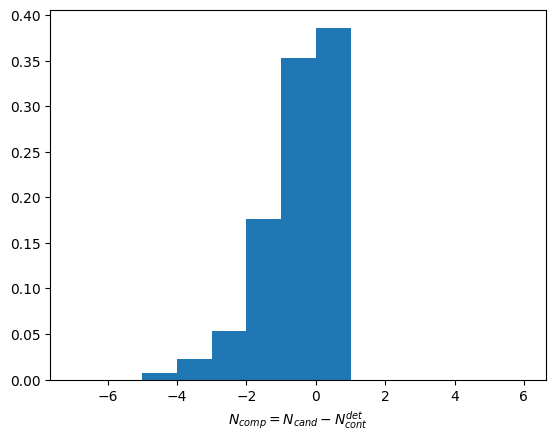

In [55]:
#with 100 sigmas and 5 N_los chosen
plt.subplots()
plt.hist(1-chosen_Ns*N_cont_det, bins=np.arange(-7, 7, 1), density=True)
plt.xlabel('$N_{comp} = N_{cand} - N_{cont}^{det}$')
#plt.xlabel('Fraction of Detection')

(array([  2.,   0.,   2.,   2.,  15.,   5.,  14.,  17.,  38., 296.]),
 array([0.83242002, 0.84914086, 0.86586171, 0.88258255, 0.89930339,
        0.91602423, 0.93274507, 0.94946592, 0.96618676, 0.9829076 ,
        0.99962844]),
 <BarContainer object of 10 artists>)

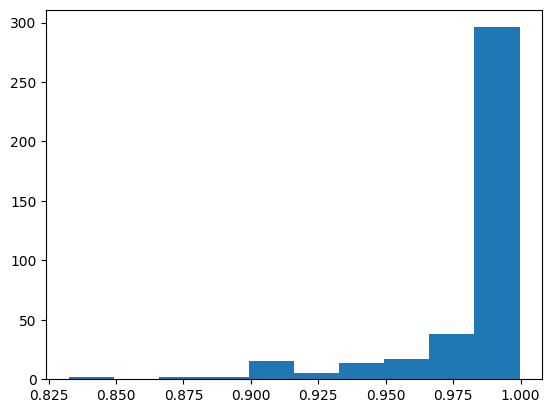

In [57]:
#with 100 sigmas and 5 N_los chosen
plt.subplots()
plt.hist(N_cont_det)#, bins=np.arange(25, 75, 1), density=True)
#plt.xlabel('$N_{comp} = N_{cand} - N_{cont}^{det}$')
#plt.xlabel('Fraction of Detection')

-----

Test scripts are below

In [128]:
def P_sig(sig, O_cont, N_cont):
    return pm.(sig*O_cont)**N_cont * np.exp(-sig*O_cont) / scipy.special.factorial(N_cont)

In [86]:
N_cand = 92
r1, r2 = 100, 1000
r3, r4 = 2000, 5000
O_cont = np.pi*(r4**2 - r3**2)
N_cont_ = N_cont_arr
sig_los = N_cont_arr/O_cont * np.pi * (r2**2 - r1**2)

*Note: missng constant = (N_cont+1)/O_cont*

In [182]:
with pm.Model() as P_siglos:
    y_obs = pm.Gamma('sig', alpha=855+1, beta=O_cont)
    sig_trace = pm.sample(draws=1000, chains=4)
    sig_forecast = pm.sample_posterior_predictive(sig_trace, var_names=['sig'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [sig]


In [188]:
sig_trace

Inference data with groups:
	> posterior
	> sample_stats

## 1000 Draws

### $\Delta m = -\frac{ln[(A - N)/B]}{c}$
$r = N(r_2^2 - r_1^2) + r_1^2$

In [376]:
def solv_delm(n_):
    a, b, c = 1.53778978, 1.49562009, 0.14470388
    return -1 * np.log((a-n_)/b) / c

def solv_r(n_):
    r1, r2 = 100, 1000
    return np.sqrt(n_ * (r2**2 - r1**2) + r1**2)

Text(0, 0.5, 'P($\\Sigma$)')

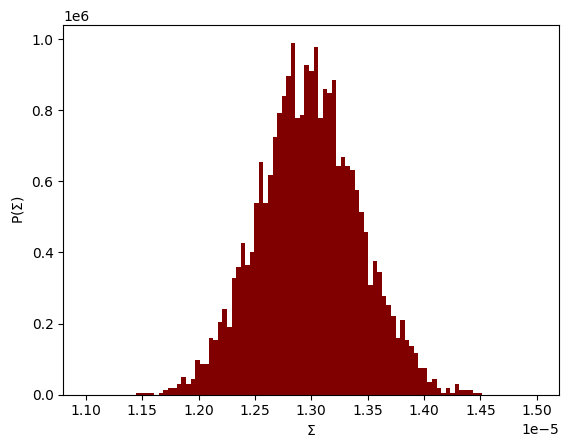

In [206]:
#with 1000 draws hist
fig, ax = plt.subplots()
ax.hist(sig_forecast.posterior_predictive['sig'].data.flatten()
        , density=True, bins=np.linspace(1.10e-5, 1.5e-5, 100), color='maroon')
ax.set_xlabel('$\Sigma$')
ax.set_ylabel('P($\Sigma$)')

Text(0, 0.5, 'P($\\Sigma$)')

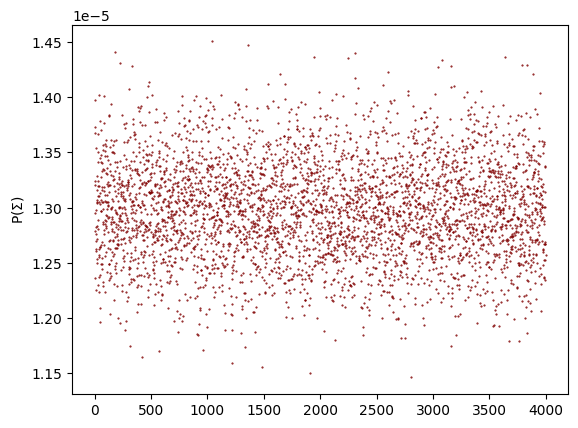

In [207]:
plt.subplots()
plt.plot(sig_forecast.posterior_predictive['sig'].data.flatten(), '.', ms=1, 
         color='maroon')
plt.ylabel('P($\Sigma$)')

In [212]:

O_comp = np.pi*(r2**2-r1**1)
r1, r2

(100, 1000)

In [240]:
for i in range(10):
    #random.seed()
    print(np.random.randint(1000000))

246216
501488
217474
386269
208693
994407
465078
909263
468670
531430


In [213]:
sig_       = sig_forecast.posterior_predictive['sig'].data.flatten()
chosen_sig = random.choice(sig_)


SEED = np.random.randint(100000)

SAMPLE_KWARGS = {"chains": 4, "tune": 1000,
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

with pm.Model() as P_Ncont:
    y_obs = pm.Poisson('Ncont', mu=chosen_sig*O_comp)
    Ncont_trace = pm.sample(draws=1000, chains=4, seed=SAMPLE_KWARGS)
    Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['Ncont'])
    
chosen_N = random.choice(N_)

n_bin, bins, a = plt.hist(N_, cumulative=True, density=True, 
                      bins=np.arange(24.5, 65.5, 1))


Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [Ncont]


In [482]:
help(pm.Exponential)

Help on class Exponential in module pymc.distributions.continuous:

class Exponential(PositiveContinuous)
 |  Exponential(name: str, *args, rng=None, dims: Union[str, Sequence[Optional[str]], NoneType] = None, initval=None, observed=None, total_size=None, transform=UNSET, **kwargs) -> pytensor.tensor.var.TensorVariable
 |  
 |  Exponential log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \lambda) = \lambda \exp\left\{ -\lambda x \right\}
 |  
 |  .. plot::
 |      :context: close-figs
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      import arviz as az
 |      plt.style.use('arviz-darkgrid')
 |      x = np.linspace(0, 3, 100)
 |      for lam in [0.5, 1., 2.]:
 |          pdf = st.expon.pdf(x, scale=1.0/lam)
 |          plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
 |      plt.xlabel('x', fontsize=12)
 |      plt.ylabel('f(x)', fontsize=12)
 |      plt.legend(loc=1)
 | 

In [484]:
#SEED = np.random.randint(100000)

#SAMPLE_KWARGS = {"chains": 4, "tune": 100,
#                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
a, b, c = pop
with pm.Model() as P_dm:
    y_obs = popt[0] - popt[1]/popt[2]*pm.Exponential('dm', lam=popt[2])
    dm_trace = pm.sample(draws=47, chains=1, random_seed=np.random.randint(100000))
    dm_forecast = pm.sample_posterior_predictive(dm_trace, var_names=['dm'])
    
#chosen_N = random.choice(N_)


NameError: name 'pop' is not defined

(array([24., 12.,  5.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.11681977e-02, 4.56067231e+00, 9.10017642e+00, 1.36396805e+01,
        1.81791846e+01, 2.27186887e+01, 2.72581929e+01, 3.17976970e+01,
        3.63372011e+01, 4.08767052e+01, 4.54162093e+01]),
 <BarContainer object of 10 artists>)

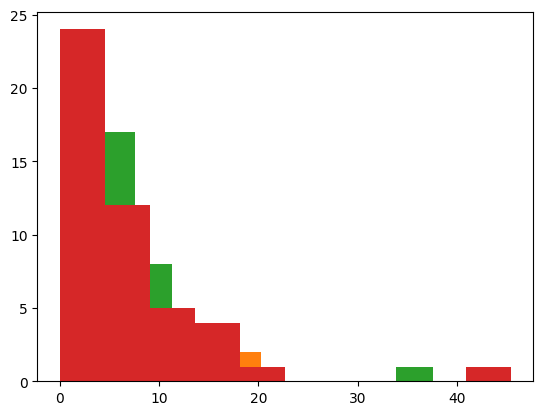

In [479]:
dm_arr = dm_forecast.posterior_predictive['dm'].data
plt.subplots()
plt.hist(dm_arr[0])
plt.hist(dm_arr[1])
plt.hist(dm_arr[2])
plt.hist(dm_arr[3])

In [ ]:
plt.xlabel('N_cont drawn from the distribution')
plt.ylabel('density of N_cont')

Text(0.5, 0, 'N_cont drawn from the distribution')

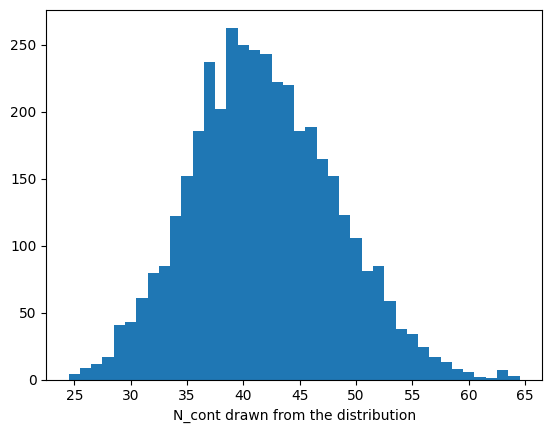

In [411]:
N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
plt.subplots()
n_bin, bins, a = plt.hist(N_,
                      bins=np.arange(24.5, 65.5, 1))
#plt.arrow(47, 0.8, -47, 0, width=0.01, color='k', length_includes_head = True,
#         head_width=0.05, head_length=2)
#plt.vlines(47, 0, 0.8, color='k', ls='--')
plt.xlabel('N_cont drawn from the distribution')
#plt.ylabel('density of N_cont')

Text(0, 0.5, 'density of N_cont')

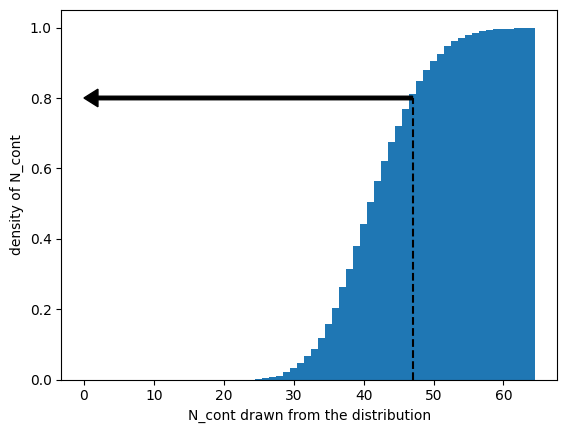

In [373]:
N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
plt.subplots()
n_bin, bins, a = plt.hist(N_, cumulative=True, density=True, 
                      bins=np.arange(24.5, 65.5, 1))
plt.arrow(47, 0.8, -47, 0, width=0.01, color='k', length_includes_head = True,
         head_width=0.05, head_length=2)
plt.vlines(47, 0, 0.8, color='k', ls='--')
plt.xlabel('N_cont drawn from the distribution')
plt.ylabel('density of N_cont')

In [402]:
solved_delm = solv_delm(n_)
solved_r    = solv_r(n_)
i_dm, i_r = int(np.round(solved_delm, 1)*10), int(np.round(solved_r/10))
frac_mtx[i_dm,i_r]

In [320]:
a, b, c = 1.53778978, 1.49562009, 0.14470388
n_ = n[np.where(bins==chosen_N-0.5)][0]
-1*np.log((a-n_)/b)/c

4.97730794152777

In [408]:
frac_mtx[i_dm,i_r]

0.9999997962190745

In [393]:
np.round(solved_delm, 1)

5.0

In [404]:
i_dm, i_r

(50, 90)